In [70]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.special import gammainc, gamma

## пункт а)
### строим эмпирическую функцию распределения чтобы найти дельту Колмогорова

In [3]:
degrees = [5, 8, 6, 12, 14, 18, 11, 6, 13, 7]
n = 100

In [4]:
sample = []
for i in range(len(degrees)):
    sample.extend([i for j in range(degrees[i])])
    
points = np.linspace(0, 9, 100)
f_emp = [np.sum(sample<el)/n for el in points]
f_acc = [x/10 for x in points]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


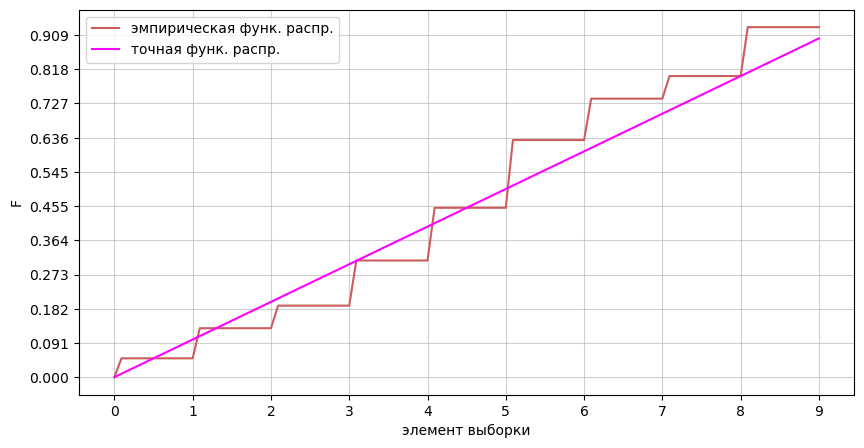

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
ax.grid()

ax.set_xticks(np.linspace(0, 10, 11))
ax.set_yticks(np.linspace(0, 1, 12))

ax.set_xlabel('элемент выборки')
ax.set_ylabel('F')

ax.grid(which="major", alpha=0.6)
ax.legend(loc='best', prop={'size': 15})

ax.plot(points, f_emp, color = 'indianred', label ='эмпирическая функ. распр.')
ax.plot(points, f_acc, color = 'magenta', label ='точная функ. распр.')

ax.legend()

In [18]:
delta = n**0.5*max(list(map(lambda x,y: abs(x-y), f_acc, f_emp)))
print(f"Оценка дельта по критерию Колмогорова = {round(delta, 2)}")

Оценка дельта по критерию Колмогорова = 1.31


In [22]:
p_val = np.sum([-2*(-1)**(i)*np.exp(-2*i**2*delta**2) for i in range(1,1000)])
print(f"p_value = {round(p_val, 3)} => нет оснований отвергать H0")

p_value = 0.065 => нет оснований отвергать H0


##  пункт b)


### Хи-квадрат

In [30]:
def gauss(x, mean, sigma):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - mean)**2 / (2 * sigma**2) )

borders = [i/10 for i in range(5, 86, 10)]
borders.insert(0, -np.inf)
borders.append(np.inf)

sigmas = np.linspace(1, 5, 100)
means = np.linspace(0, 7, 100)

In [31]:
l_max = 0
p_best = tuple()
for sigma in sigmas:
    for mean in means:
        p = []
        for i in range(len(borders) - 1):
            p.append(integrate.quad(gauss, borders[i], borders[i+1], args = (mean, sigma))[0])
        l = np.prod(list(map(lambda x, y: x**y, p, degrees)))
        if l > l_max:
            l_max = l
            p_best = (mean, sigma)

In [32]:
print(f"Оценка параметров для нормального распределения по выборке : sigma = {round(p_best[1], 2)}, a = {round(p_best[0], 2)}")

Оценка параметров для нормального распределения по выборке : sigma = 2.7, a = 4.81


In [33]:
mean, sigma = p_best
p_all = []
for i in range(len(borders) - 1):
    p_all.append(integrate.quad(gauss, borders[i], borders[i+1], args = (mean, sigma))[0])

In [63]:
deltas = []
for i in range(10):
    deltas.append((degrees[i] - n*p_all[i])**2/(n*p_all[i]))
delta_hi = np.sum(deltas)

In [64]:
print(f"Оценка дельта с помощью критерия хи-квадрат равняется {round(delta_hi, 2)}")

Оценка дельта с помощью критерия хи-квадрат равняется 9.77


### Колмогоров

In [41]:
N = 50000
sample_first = []
for i in range(len(degrees)):
    sample_first.extend([i for j in range(degrees[i])])
    
deltas_kolm = []
for i in range(N):
    sample = np.random.normal(mean, sigma, n)
    points = np.linspace(0, max(max(sample), 9), 100)
    f1 = [np.sum(sample<elem)/n for elem in points]
    f2 = [np.sum(sample_first<elem)/n for elem in points]
    tmp = 10*max(list(map(lambda x,y: abs(x-y), f1, f2)))
    deltas_kolm.append(tmp)

In [39]:
deltas_var = np.sort(deltas_kolm)
k = len(deltas_var[deltas_var<1.299999])
p_value = 1-((k-1)/N)
print(f"p_value = {round(p_value, 2)} => нет оснований отвергать H0")

p_value = 0.53 => нет оснований отвергать H0


## пункт c)
### хи - квадрат

In [51]:
mean = np.mean(sample_first)
sigma = np.std(sample_first)
print(f' оценка по изначальной выборке : a = {mean}, sigma {np.round(sigma,2)}')

 оценка по изначальной выборке : a = 4.77, sigma 2.51


In [57]:
deltas_omm = []
N = 50000
for i in range(N):
    sample = np.random.normal(mean, sigma, n)
    mean_tmp = np.mean(sample)
    sigma_tmp = np.std(sample)
    p_c = []
    for i in range(len(borders) - 1):
        p_c.append(integrate.quad(gauss, borders[i], borders[i+1], args = (mean_tmp, sigma_tmp))[0])
    
    num_in_intervals = [len(sample[(sample >= borders[i]) & (sample <= borders[i+1])]) for i in range(len(borders)-1)]
    deltas_omm.append(sum(((num_in_intervals[i] - n*p_c[i])**2)/(n*(p_c[i]+0.00001)) for i in range(len(p_c))))

In [68]:
deltas_var_omm = np.sort(deltas_omm)
k_omm = len(deltas_var_omm[deltas_var_omm<delta_hi])
k_omm

39063

In [66]:
p_value_omm = 1-((k_omm-1)/N)
print(f"p_value = {round(p_value_omm, 2)} = нет оснований отвергнуть H0")

p_value = 0.22 = нет оснований отвергнуть H0


In [75]:
def cdf_chi2(x, k):
    return 3*gammainc(k/2, x/2)/gamma(k/2)

points = np.linspace(0, 30, 1000)
chi_7 = []
chi_9 = []
for x in points:
    chi_7.append(integrate.quad(chi2.pdf, 0, x, args=7)[0])
    chi_9.append(integrate.quad(chi2.pdf, 0, x, args=9)[0])
    
deltas_func = [len(deltas_var_omm[deltas_var_omm<x])/N for x in points]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


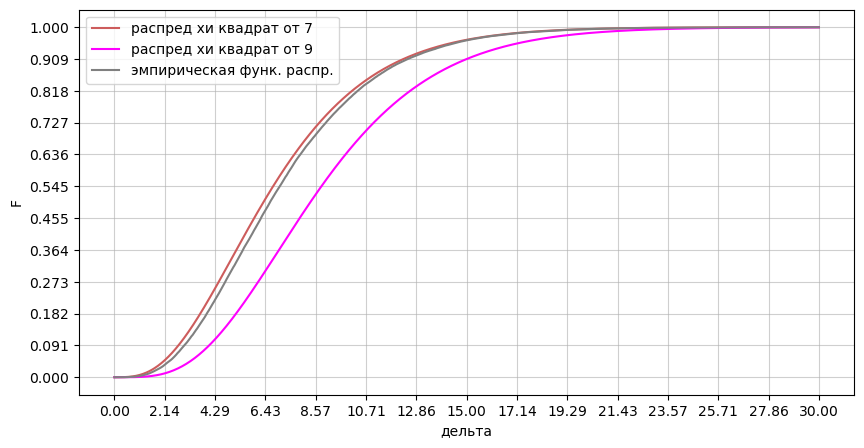

In [82]:
fig, ax = plt.subplots(figsize=(10,5))
ax.grid()

ax.set_xticks(np.linspace(0, max(points), 15))
ax.set_yticks(np.linspace(0, 1, 12))

ax.set_xlabel('дельта')
ax.set_ylabel('F')

ax.grid(which="major", alpha=0.6)
ax.legend(loc='best', prop={'size': 15})

ax.plot(points, chi_7, color = 'indianred', label ='распред хи квадрат от 7')
ax.plot(points, chi_9, color = 'magenta', label ='распред хи квадрат от 9')
ax.plot(points, deltas_func, color = 'grey', label ='эмпирическая функ. распр.')

ax.legend()